### Initialization

In [2]:
# import
import Untitled as da
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

[-3. -1.  0.  0.  0.  5.]


In [3]:
# constants


In [4]:
# measured data
data, notes, conditions = da.import_data()

Δmono = 0.5 # nm
ΔU = 1 # mV
U_0 = 2 # mV
Δa = 1 # °

a_1 = data[0][0] # °
U_1 = data[0][1] # mV
λ_1 = 600 # nm

λ_2 = [768, 905, 1060] # nm
mono_2 = [data[1][0], data[2][0], data[3][0]] # nm
U_2 = [data[1][1], data[2][1], data[3][1]] # mV

mono_la = data[6][0] # nm
U_la = [data[6][1], data[6][2], data[6][3]] # mV

mono_si = [data[7][0], data[8][0]] # nm
U_si = [data[7][1], data[8][1]] # mV

mono_ga = [data[4][0], data[5][0]] # nm
U_ga = [data[4][1], data[5][1]] # mV

From Data the following files were imported:

varname               filename             shape      conditions                       notes                       

data[0]   :           v44_1.txt           2 x 19          0      ['lambda = 600 nm'];  ['delta = 1°', 'delta = 1mV'
data[1]   :           v44_2a.txt          2 x 31          0      ['lambda = 768 nm'];  ['delta = 0.5nm', 'delta = 1
data[2]   :           v44_2b.txt          2 x 31          0      ['lambda = 905 nm'];  ['delta = 0.5nm', 'delta = 1
data[3]   :           v44_2c.txt          2 x 36          0      ['lambda = 1060 nm'];  ['delta = 0.5nm', 'delta = 
data[4]   :           v44_gaas.txt        2 x 52          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[5]   :           v44_gaas_cooled.txt 2 x 61          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[6]   :           v44_lamp.txt        4 x 41          0      ['delta = 0.5nm' 'delta = 1mV' 'delta = 1mV' 'delt
data[7]   :           v44

In [33]:
# theoretical functions
def lin(x, a, b):
    return a*x + b

### Linearity of the photo diode

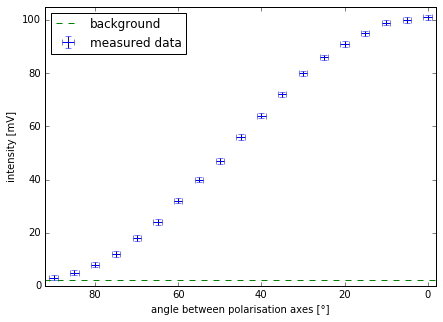

In [27]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(a_1, U_1, xerr=Δa, yerr=ΔU, fmt='none', label='measured data')
ax.axhline(2, ls='--', c='g', label='background')
ax.set_xlim(-2, 92)
ax.set_ylim(0, 105)
ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel('angle between polarisation axes [°]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_plot.pdf')

In [68]:
opt_1, cov_1 = curve_fit(lin, np.sin(a_1*np.pi/180)**2, U_1 - U_0)

sin2 = np.sin((a_1 - 90)*np.pi/180)**2
Δsin2 = 2*np.sin((a_1 - 90)*np.pi/180)*np.cos((a_1 - 90)*np.pi/180)*np.pi/180*Δa
sigma_1 = np.sqrt(ΔU**2 + (opt_1[0]*Δsin2)**2)

opt_1, cov_1 = curve_fit(lin, sin2, U_1 - U_0, sigma = sigma_1, absolute_sigma = True)
err_1 = np.sqrt(np.diag(cov_1))
χ2_1 = sum((U_1 - U_0 - lin(sin2, *opt_1))**2/sigma_1**2)/(len(U_1) - len(opt_1))

opt_1, err_1, χ2_1

(array([ 96.76710603,   3.30739087]),
 array([ 0.75149073,  0.48922428]),
 1.2583523034757724)

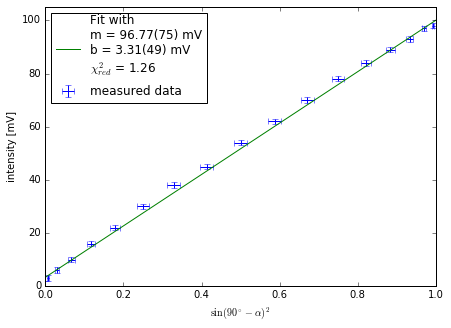

In [73]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(sin2, U_1 - U_0, xerr=Δsin2, yerr=ΔU, fmt='none', label='measured data')
x = np.linspace(0, 1, 100)
ax.plot(x, lin(x, *opt_1), label="""Fit with
m = %.2f(%.f) mV
b = %.2f(%.f) mV
$\chi^2_{red}$ = %.2f"""%(opt_1[0], 10**2*err_1[0], opt_1[1], 10**2*err_1[1], χ2_1))
ax.set_ylim(0, 105)
#ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel(r'$\sin(90^\circ-\alpha)^2$')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_fit.pdf')

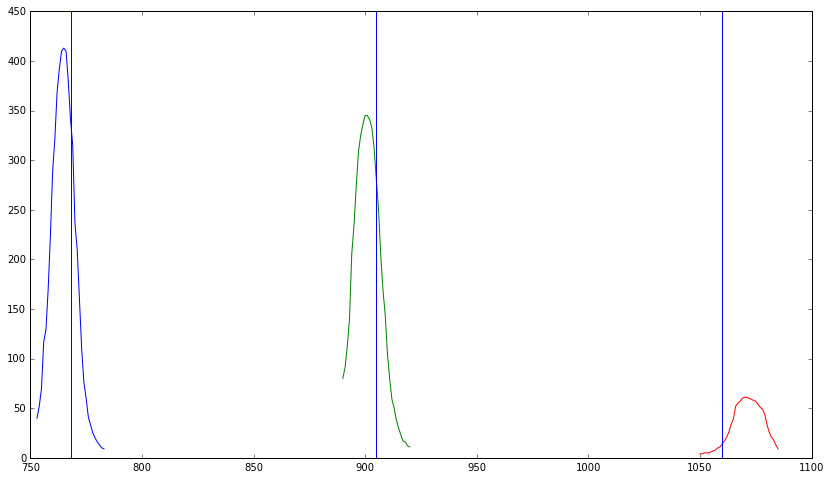

In [15]:
# plots
fig,ax = plt.subplots(figsize=(14,8))

ax.plot(data[1][0],data[1][1],data[2][0],data[2][1],data[3][0],data[3][1])
ax.axvline(768)
ax.axvline(905)
ax.axvline(1060)

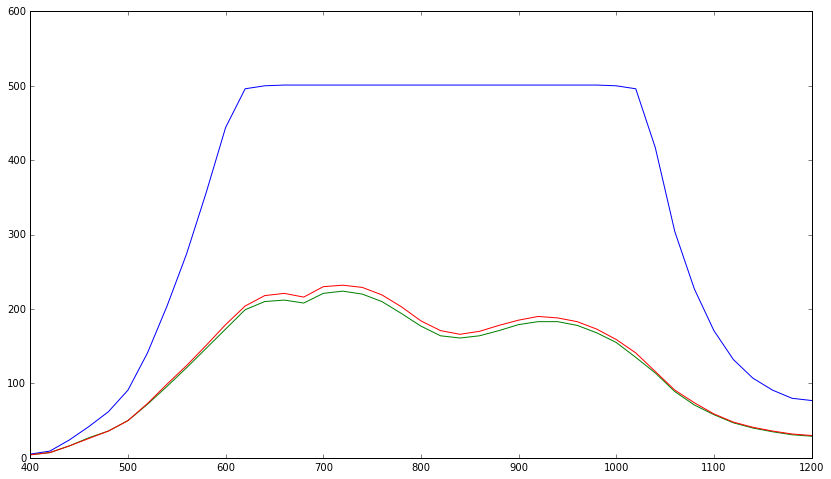

In [8]:
# plots
fig,ax = plt.subplots(figsize=(14,8))

ax.plot(data[6][0],data[6][1],data[6][0],data[6][2],data[6][0],data[6][3])

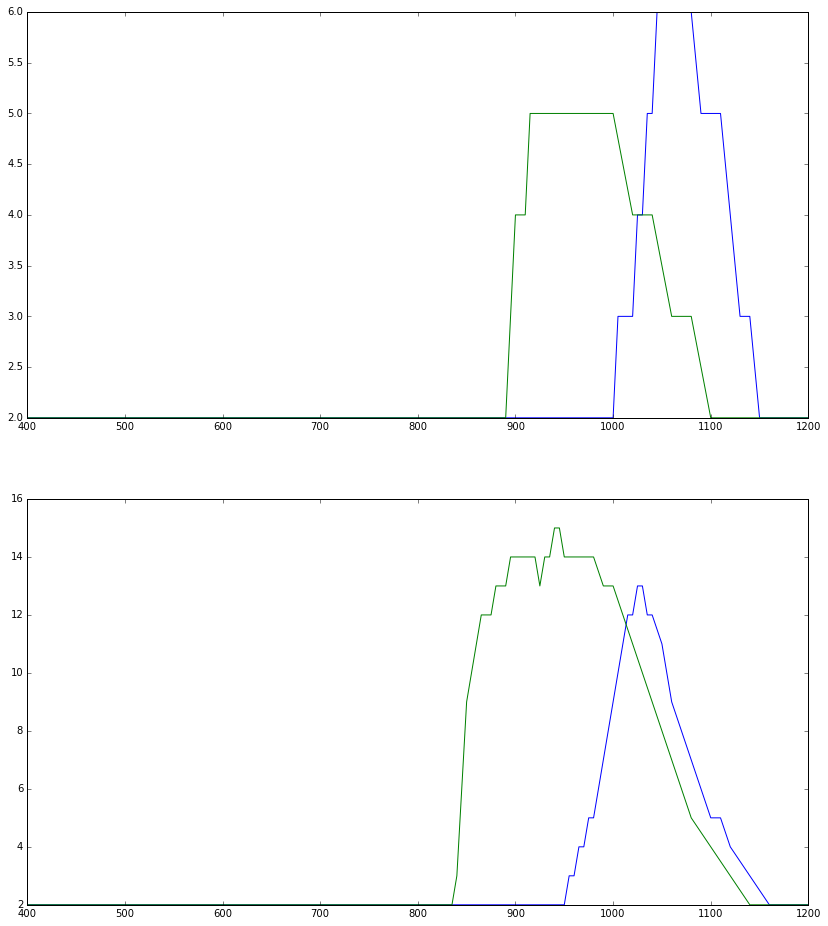

In [12]:
# plots
fig,ax = plt.subplots(2,1,figsize=(14,16))

ax[0].plot(data[7][0],data[7][1],data[4][0],data[4][1])
ax[1].plot(data[8][0],data[8][1],data[5][0],data[5][1])